# CHAPTER 3: Classification

### MNIST

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)


In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [4]:
X, y = mnist["data"], mnist['target']

- MNIST consist of 70000 instances, and each have 784 features. (28 x 28 pixels)
- Each feature simple represents one pixel's intensity from 0(white) to 255(black)

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

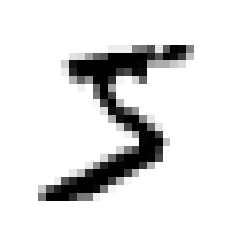

In [7]:
# Lets have a look at an example

import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
# Since X[0] is plain array that includes 28x28 = 784 elemets, convert it to 28x28 matrix
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [8]:
y[0]

'5'

In [9]:
# Since the target values are string, lets cast y to integer

import numpy as np
y = y.astype(np.uint8)

In [10]:
y[0]

5

- Showing the examples

In [11]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [12]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

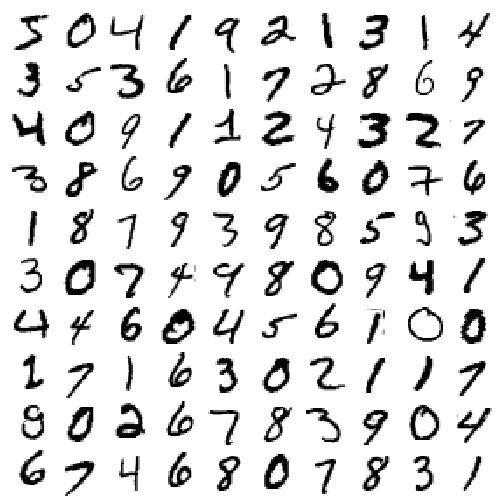

In [13]:

plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

In [14]:
# scikit learn have already distinguished data well on index 60000.
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Training a Binary Classifier

- Let’s simplify the problem for now and only try to identify one digit—for example, the number 5.
- It will be binary classifier, capable of distinguishing between just two classes, 5 and not 5.

In [15]:
# create the vectors, True for all 5s, False for all other digits.

y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

In [16]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [17]:
# some_digit = 5, defined before
sgd_clf.predict([some_digit])

array([ True])

- The classifier guesses that this image represents 5 (True)

### Performance Measures

- Evaluating a classifier is often significantly trickier than evaluating a regressor.

#### Measuring Accuracy Using Cross-Validation
A good way to evaluate a model is to use cross-validation. Lets do it in two different ways.

**Implementing Cross-Validation (without using cross_val_score())**

- Occasionally you will need more control over the cross-validation process than what Scikit-Learn provides off the shelf. In these cases, you can implement cross-validation yourself.
- In below example, we will use StratifiedKFold and folds will have approximately same amount of 5 and not 5 labels.

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# number of folds is 3.
# stratified fold will divide the set as it includes same proportion of 5 and not 5 target values
skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# this for loop will run 3 times for each fold
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    
    X_train_folds = X_train[train_index]
    y_train_folds = y_train[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    
    n_correct = sum(y_pred == y_test_fold)
    print( n_correct / len(y_pred))

0.8642
0.87215
0.88795


- The StratifiedKFold class performs stratified sampling to produce folds that contain a representative ratio of each class.

**Implementing Cross Validation (with using cross_val_score())**

In [19]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

- The ratio of correct predictions are above %93.
- Even it looks high, it is not enough to judge this model.
- Lets define a model that always predicts not 5.

In [20]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X),1),dtype=bool)

In [21]:
never_5_clf = Never5Classifier()

cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

- Accuracy is over 90%. But, this model is sucks. 
- The reason is simple because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time.
- This demonstrates why accuracy is generally not preferred performance measure for classifiers. (especially when you are dealing with **skewed datasets**.

#### Confusion Matrix

- Just like the cross_val_score() function, cross_val_predict() performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. 
- **cross_val_predict()**: The function cross_val_predict has a similar interface to cross_val_score, **but returns, for each element in the input, the prediction that was obtained for that element when it was in the test set.** Only cross-validation strategies that assign all elements to a test set exactly once can be used (otherwise, an exception is raised).

In [22]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [23]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

- Each row in a confusion matrix represents an actual class, while each column represents a predicted class.

In [24]:
# For a perfect predictor
# when all predictions are exactly same with the target values

y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

#### Precision and Recall

In [25]:
from sklearn.metrics import precision_score, recall_score

In [26]:
# When the model claims an image represents a 5, it is correct as ...
# (3530) / (3530+687)
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [27]:
# The model detects ... percent of the 5s.
# (3530) / (3530+1891)
recall_score(y_train_5, y_train_pred)

0.6511713705958311

- Based on precision and recall the model is not as good as accuracy metric shows.
- It is often convenient to combine precision and recall into a single metric called the **F1 score**

**F1 Score (Harmonic mean of precision and recall)**

- The classifier will only get a high F1 score if both recall and precision are high.

In [28]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

#### Precision/Recall Trade-off

- To understand this trade-off, let’s look at how the SGDClassifier makes its classification decisions. For each instance, it computes a score based on a decision function. 
- If that score is greater than a threshold, it assigns the instance to the positive class; otherwise it assigns it to the negative class.
- Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions. 
- Instead of calling the classifier’s predict() method, you can call its decision_function() method, which returns a score for each instance, and then use any threshold you want to make predictions based on those scores:

**Note: SGD classifier uses a threshold equal to 0**

In [29]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [30]:
# If you set your threshod lower than the above value, it will classify this as positive (it will say it is 5.)
# If you set your threshod higher than the above value, it will classify this as negative (it will say it is not 5.)
threshold = 0

y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [31]:
threshold = 8000

y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

- How do you decide which threshold to use?
- Use the cross_val_predict() function to get the scores of all instances in the training set, but this time specify that you want to return decision scores instead of predictions

In [32]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=5, method='decision_function')

In [33]:
y_scores

array([  4411.53413566, -14087.12193543, -21565.51993633, ...,
         9394.4695853 ,  -2918.25117218,  -9160.6081938 ])

In [34]:
# compute precision and recall for all possible thresholds

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [35]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown

In [36]:
#Ex: np.argmax() will give you the first index of the maximum value
ex1 = np.array([1,2,3,4,5,15,2,5])
np.argmax(ex1 > 10)

5

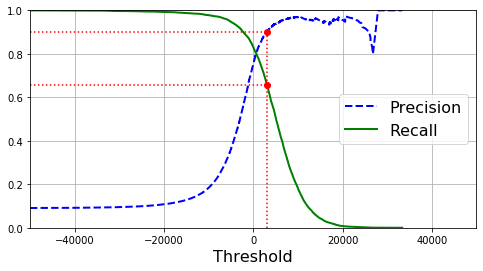

In [37]:
# (np.argmax() will give you the first index of the maximum value
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown                                            # Not shown
plt.show()

- You may wonder why the precision curve is bumpier than the recall curve. The reason is that precision may sometimes go down when you raise the threshold (although in general it will go up). On the other hand, recall can only go down when the threshold is increased, which explains why its curve looks smooth.

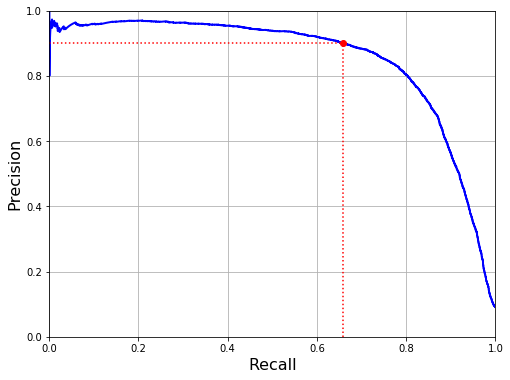

In [38]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

- Let's do predictions again with another threshold that yields precision=0.90

In [39]:
# get the recall and threshold values for precisions<=0.90
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [40]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

# Check the metrics
precision_score(y_train_5, y_train_pred_90)

0.9002016129032258

In [41]:
# this is same with recall_90_precision
recall_score(y_train_5, y_train_pred_90)

0.6589190186312488

#### The ROC Curve

- The **receiver operating characteristic (ROC)** curve is another common tool used with binary classifiers.
-  the ROC curve plots the true positive rate (another name for recall) against the false positive rate (FPR). The FPR is the ratio of negative instances that are incorrectly classified as positive. 

In [42]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [43]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)

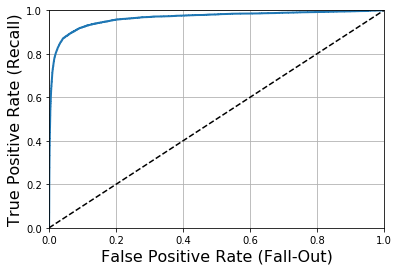

In [44]:
plot_roc_curve(fpr,tpr)
plt.show()

- The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

**AUC (Area Under Curve)**

In [45]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9648211175804801

**Comparison of different model's ROC curves**

- We have the ROC curve and ROC AUC score for SGDClassifier.
- Lets find them for RandomForestClassifier.
- RandomForestClassifier class does not have a decision_function() method that returns scores.
 - Instead, it has predict_proba() method which returns array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class. (e.g., 70% chance that the image represents a 5):

In [46]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

- The roc_curve() function expects labels and scores, but instead of scores you can give it class probabilities.

In [47]:
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [48]:
y_scores_forest = y_probas_forest[:,1] # score=proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

<function matplotlib.pyplot.show(*args, **kw)>

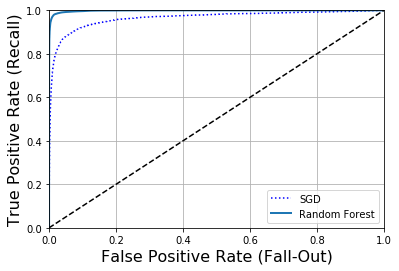

In [49]:
# plot the first ROC Curve (curve of SGDClassifier)
plt.plot(fpr,tpr,"b:", label='SGD')
# plot the second ROC Curve (curve of Random Forest)
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc='lower right')
plt.show

In [50]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

- As a result,
 - RandomForest is better(superior) than SGDClassifier, since
  - Its ROC curve is much closer to the top left corner, and it has a greater AUC

In [51]:
##### Your trials ######

# instead of returning predict_proba, this will return the predictions. (method='predict' by default)
y_forest_predictions = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
y_forest_predictions

array([ True, False, False, ...,  True, False, False])

In [52]:
confusion_matrix(y_train_5, y_forest_predictions)

array([[54534,    45],
       [  725,  4696]], dtype=int64)

In [53]:
precision_score(y_train_5, y_forest_predictions)

0.9905083315756169

In [54]:
recall_score(y_train_5, y_forest_predictions)

0.8662608374838591

Conclusion
- You now know how to train binary classifiers, choose the appropriate metric for your task, evaluate your classifiers using cross-validation, select the precision/recall trade-off that fits your needs, and use ROC curves and ROC AUC scores to compare various models. Now let’s try to detect more than just the 5s.

#### Multiclass Classification

- Whereas binary classifiers distinguish between two classes, multiclass classifiers (also called multinomial classifiers) can distinguish between more than two classes.
- Some algorithms (such as Logistic Regression classifiers, Random Forest classifiers, and naive Bayes classifiers) are capable of handling multiple classes natively. 
- Others (such as SGD Classifiers or Support Vector Machine classifiers) are strictly binary classifiers. However, there are various strategies that you can use to perform multiclass classification with multiple binary classifiers.

**How to perform multiclass classification with binary classifier?**
1. One versus the Rest (OvR) strategy: One way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. This is called the one-versus-the-rest (OvR) strategy (also called one-versus-all).

2. One versus One (OvO) strategy: Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. This is called the one-versus-one (OvO) strategy. If there are N classes, you need to train N × (N – 1) / 2 classifiers. For the MNIST problem, this means training 45 binary classifiers! When you want to classify an image, you have to run the image through all 45 classifiers and see which class wins the most duels. The main advantage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.

Some algorithms (such as Support Vector Machine classifiers) scale poorly with the size of the training set. For these algorithms OvO is preferred because it is faster to train many classifiers on small training sets than to train few classifiers on large training sets. For most binary classification algorithms, however, OvR is preferred.

**Support Vector Classifier**

In [55]:
# Lets train Support Vector Classifier
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train is used. Not y_train_5, because this time since we are doing multiclass classification
svm_clf.predict([some_digit])

array([5], dtype=uint8)

- It predicted correctly.
-  Under the hood, Scikit-Learn actually used the OvO strategy: it trained 45 (Nx(N-1)/2 = 10x9/2) binary classifiers, got their decision scores for the image, and selected the class that won the most duels.

- If you call the decision_function() method, you will see that it returns 10 scores per instance (instead of just 1). 
- That’s one score per class (it’s the number of won duels plus or minus a small tweak to break ties, based on the binary classifier scores):
- The highest score is the one corresponding to class 5.

In [56]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [57]:
# return the index of the max value
np.argmax(some_digit_scores)

5

In [58]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [59]:
svm_clf.classes_[np.argmax(some_digit_scores)]

5

 - **Warning** : When a classifier is trained, it stores the list of target classes in its classes_ attribute, ordered by value. In this case, the index of each class in the classes_ array conveniently matches the class itself (e.g., the class at index 5 happens to be class 5), but in general you won’t be so lucky

- If you want to force Scikit-Learn to use one-versus-one or one-versus-the-rest, you can use the OneVsOneClassifier or OneVsRestClassifier classes. 
- But, since SVC is working slowly when the volume of data is high, if you use OneVsRest, it will take much more time than OvO.
 - In OvO, there was 45 classifiers. (0s vs 1s, 0s vs 2s, 0s vs 3s ...)
 - In OvR, there are 10 classifiers. (0s vs not 0s, 1s vs not 1s, ...)

In [60]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [61]:
# For One versus Rest, there are 10 estimators.
# Estimator for 0s versus not 0s, 1s versus not 1s ...
ovr_clf.estimators_

[SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=False, random_state=None, shrinking=True,
     tol=0.001, verbose=False),
 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=False, random_state=None, shrinking=True,
     tol=0.001, verbose=False),
 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=False, random_state=None, shrinking=True,
     tol=0.001, verbose=False),
 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=False, random_state=None, shrinking=True,
     tol=0.0

**Stochastic Gradient Descent Classifier**

In [62]:
# Lets train Stochastic Gradient Descent classifier
# It is using OvR strategy by default
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

- This time Scikit-Learn used the OvR strategy under the hood: since there are 10 classes, it trained 10 binary classifiers. 
- The decision_function() method now returns one value per class. Let’s look at the score that the SGD classifier assigned to each class

In [63]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

- It predicts 3 instead of 5. 
- As usual, you can use cross-validation.
- Use the cross_val_score() function to evaluate the SGDClassifier’s accuracy:

In [64]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

- It gets over 84% on all test folds.
- If you used a random classifier, you would get 10% accuracy, so this is not such a bad score, but you can still do much better. 
- Simply **scaling** the inputs increases accuracy above 89%:

In [65]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

#### Error Analysis

- Lets assume that we have found a promising model and want to find ways to improve it.
- One way to do this is to analyze the types of errors it makes.
- First, look at the **confusion matrix**

In [66]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

In [67]:
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

- Rows present actual classes, while columns represent predicted classes.
- Lets look at image representation of the confusion matrix

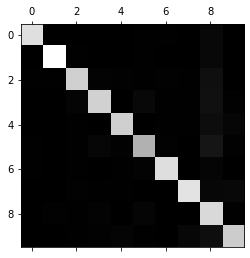

In [68]:
# the lighter cells represents the greater number
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

- Most of the instances are on the main diagonal. That means they are classified correctly.
- The Cell (5,5) is slightly darker than the others in the main diagonal. could mean that there are fewer images of 5s in the dataset or that the classifier does not perform as well on 5s as on other digits.

- To focus the errors, we can divide each value in the confusion matrix by the number of images in the corresponding class.
- you can compare error rates instead of absolute numbers of errors (which would make abundant classes look unfairly bad)

In [69]:
row_sums = conf_mx.sum(axis=1, keepdims=True)

#normalized confusion matrix
norm_conf_mx = conf_mx / row_sums

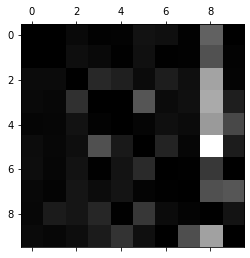

In [70]:
# Fill the diagonal with zeros to keep only the errors
# To make diagonal dark. Remember: lighter colors represents high numbers
np.fill_diagonal(norm_conf_mx,0)

plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

- The column for class 8 is quite bright, which tells you that many images get misclassified as 8s.
- However, the row for class 8 (actual) is not that bad, telling you that actual 8s in general get properly classified as 8s.
- It can be seen that 3s and 5s often get confused (in both direction)

- Analyzing the confusion matrix often gives you insights into ways to improve your classifier.- Analyzing the confusion matrix often gives you insights into ways to improve your classifier.
- it seems that your efforts should be spent on reducing the false 8s. For example,
 - you could try to gather more training data for digits that look like 8s (but are not) so that the classifier can learn to distinguish them from real 8s.
 - Or, you could engineer new features that would help the classifier
  - Ex: writing an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5 has none)
  - Or you could preprocess the images (e.g., using Scikit-Image, Pillow, or OpenCV) to make some patterns, such as closed loops, stand out more.

- Analyzing individual errors can also be a good way to gain insights on what your classifier is doing and why it is failing, but it is more difficult and time-consuming.
-  For example, let’s plot examples of 3s and 5s (the plot_digits() function just uses Matplotlib’s imshow() function. (defined in cell 55)

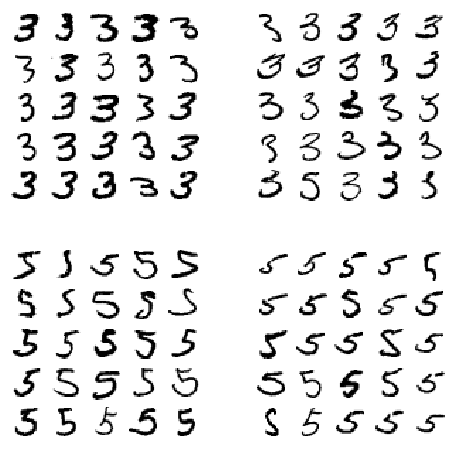

In [71]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]  # actual is cl_a, predicted is cl_a
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

# error analysis digits plot
plt.figure(figsize=(8,8))
# index 1 of 2x2 matrix figure, it is same with plt.subplot(2, 2, 1), 1.row 1.column
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
# index 2 of 2x2 matrix figure, 1.row 2.column
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
# index 3 of 2x2 matrix figure,  2.row 1.column
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
# index 4 of 2x2 matrix figure, 2.row 2.column
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

- Couple of images are really badly written and misclassifier. But there are still good written digits that are classified wrongly.
- It might be because of used model SGDClassifier, which is a linear model.
 - All it does is assign a weight per class to each pixel, and when it sees a new image it justs sums up the weighted pixel intensities to get a score for each class. 
 - So since 3s and 5s differ only by a few pixels, this model will easily confuse them.

#### Multilabel Classification

- In some cases you may want your classifier to output multiple classes for each instance
- Ex: Face-recognition classifier: what should it do if it recognizes several people in the same picture? It should attach one tag per person it recognizes. Say the classifier has been trained to recognize three faces, Alice, Bob, and Charlie. Then when the classifier is shown a picture of Alice and Charlie, it should output [1, 0, 1] (meaning “Alice yes, Bob no, Charlie yes”)
- Such a classification system that outputs multiple binary tags is called a multilabel classification system.

In [72]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)     # returns list of True,False based on condition
y_train_odd = (y_train % 2 == 1)    # returns list of True,False based on condition
y_multilabel = np.c_[y_train_large, y_train_odd]

In [73]:
# This code creates a y_multilabel array containing two target labels for each digit image
y_multilabel

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]])

In [74]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digit])

array([[False,  True]])

- Some digit was 5. (some_digit = 5)
- So, it classified correctly for two different labels. 5 < 7, and 5 is odd.

**Evaluation of Multilabel Classifier**

- The metric depends on the project. But, any binary classifier metric (ROC, AUC, precision, F1 etc.) can be used for measuring each individual label, and then simple compute the average score. (Note: this approach assumes that all labels are equally important)

In [75]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

- Sometimes, not all labels are equally important. For example, may be classifying odd is more important than classifying large.
- One simple option is to give each label a weight equal to its support (i.e., the number of instances with that target label). To do this, simply set **average="weighted"** in the preceding code

#### Multioutput Classification

- It is simply a generalization of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values).
- Lets create an example set.
 - X includes the noisy data set.
 - y includes the original X values (not noisy)
 - Notice that the classifier’s output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255).


In [76]:
# create the training and test sets by taking the MNIST images and adding noise to their pixel intensities with randint() function
# 24x24 = 784 pixels per instance, there are len(X_train) instances, generate random number between 0 and 100
noise = np.random.randint(0,100, size=(len(X_train),784))

# add noisy data to the new X
X_train_mod = X_train + noise

#do the same for X_test
noise = np.random.randint(0,100, size=(len(X_test),784))
X_test_mod = X_test + noise

# now, the y (target) is the original X instances for this example (clean images)
# while X is the noisy original X values (noisy images)
# the example case: by using noisy images and clean images we will train a model.
# then by using that model, we will try to predict clean images from noisy images
y_train_mod = X_train
y_test_mod = X_test

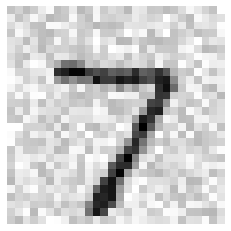

In [77]:
# ex
some_index = 0
plot_digit(X_test_mod[some_index])

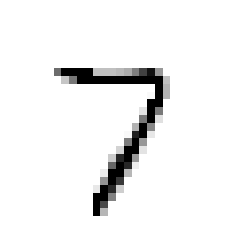

In [78]:
knn_clf.fit(X_train_mod, y_train_mod)
predicted_clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(predicted_clean_digit)

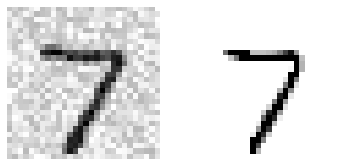

In [79]:
# EXTRA: lets use subplot to plot both in one go

plt.subplot(121)
plot_digit(X_test_mod[some_index])
plt.subplot(122)
plot_digit(predicted_clean_digit)


# EXERCISES

**1**. Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the KNeighborsClassifier works quite well for this task; you just need to find good hyperparameter values (try a grid search on the weights and n_neighbors hyperparameters).

**Warning: the next cell may take hours to run, depending on your hardware.**

In [81]:
from sklearn.neighbors import KNeighborsClassifier

# create the model by defaulft parameters
knn_clf = KNeighborsClassifier()

# define the parameters for fine tuning
param_knn = {
    'n_neighbors': [3,4,5],
    'weights' : ['uniform', 'distance']
}

from sklearn.model_selection import GridSearchCV

clf_GridSearchCV = GridSearchCV(estimator = knn_clf, 
                                cv = 5,
                                param_grid = param_knn, 
                                scoring='accuracy', 
                                return_train_score=True, 
                                )

clf_GridSearchCV.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [3, 4, 5],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=0)

In [82]:
clf_GridSearchCV.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [83]:
clf_GridSearchCV.best_score_

0.9716166666666666

In [84]:
from sklearn.metrics import accuracy_score

y_pred = clf_GridSearchCV.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714